## Example for climate indices calculation

This notebook shows how to calculate climate indices, relevant for viticulture, from the observations.

### Setup and configuration

In [1]:
rm(list=ls())
library(transformeR) # part of climate4R:  data manipulation and analysis
library(visualizeR) # part of climate4R: visualization
library(lattice) # to use some functionalities of spplot directly 
library(sp) 
library(RColorBrewer) # color themes


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.5) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.



Set the working directory, where some already prepared data can be found:

In [ ]:
work.dir <- "/home/jovyan/data/"

The following is needed to plot maps with Italian provinces:

In [3]:
# provinces polygon
sh <- readRDS(paste0(work.dir,"italy_admin.rds")) # read shape file
proj4string(sh) = CRS("+init=epsg:4326")
sh = as(sh, "SpatialPolygons")

# plot limits
lats <- c(45.45,46.15)
lons <- c(11.7,12.8)

Warning message in `proj4string<-`(`*tmp*`, value = new("CRS", projargs = "+init=epsg:4326")):
“A new CRS was assigned to an object with an existing CRS:
+proj=longlat +datum=WGS84 +no_defs
without reprojecting.
For reprojection, use function spTransform”


In [4]:
load(paste0(work.dir,"/observations_subset_1991-2020.Rdata"))

### Climate indices calculation

The following table summarizes all indices considered since they have an impact on viticulture. They all are calculated for April-September.

| Variable | Description | Short name (unit) |
|:---|:-:|---:|
| Daily mean temperature | Daily mean temperature | Tmean (ºC) |
| Daily maximum temperature | Number of days with Tmax > 30ºC | TX30 (days) |
| Daily maximum temperature | Number of days with Tmax > 35ºC | TX35 (days) |
| Daily maximum temperature | Number of events with at least 5 consecutive days with Tmax > 30 | HW30 (# events) |
| Daily maximum temperature | Number of events  with at least 3 consecutive days with Tmax > 35 | HW35 (# events)|
| Daily minimum temperature| Number of days  with Tmin > 18ºC | TN18 (days) |
| Daily minimum temperature| Number of days  with Tmin > 20ºC | TN20 (days) |
| Daily accumulated precipitation| Number of days with Precip > 5mm | PR5 (days) |
| Daily accumulated precipitation| Mean number of consecutive days with Precip <1mm | CDD (days) |
| Daily accumulated precipitation| Precipitation sum for each month | PrACC (mm) |
| Daily mean relative humidity | Number of days with Rel.Hum. > 85% | HU85 (days)|

#### Temperature indices

In [5]:
Tmean <- aggregateGrid(subsetGrid(tasmean_obs, season=4:9), aggr.y = list(FUN = mean, na.rm = TRUE))

[2026-02-24 16:39:22.09242] Performing annual aggregation...

[2026-02-24 16:39:22.100202] Done.



[2026-02-24 16:39:22.120094] - Computing climatology...



[2026-02-24 16:39:22.121044] - Done.



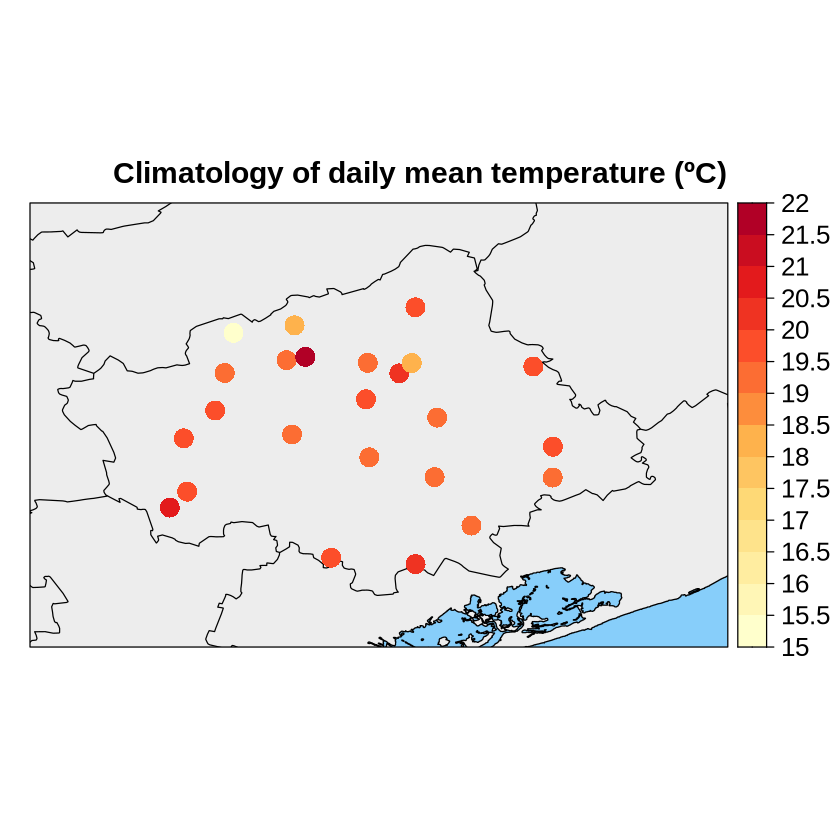

In [6]:
bk <-  seq(15,22,0.5)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlOrRd"))
cmap <- cols(cmap.nbins)
spatialPlot(climatology(Tmean), cex=2, xlim=lons, ylim=lats, 
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Climatology of daily mean temperature (ºC)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

Next, we calculate threshold-based indices for temperature. First, we select the season of interest (April-September), then exceedances are calculated for each year to have a multi-year series. In this example, TN20 is calculated, same code could be used for TN18, and TX30 and TX35 based on daily maximum temperature.

In [7]:
years <- unique(getYearsAsINDEX(tasmin_obs))
ls <-lapply(1:length(years), function(yy){
	obs.y <- subsetGrid(tasmin_obs, years=years[yy], season=4:9) # change variable here if needed
	index <- subsetDimension(obs.y, dimension="time",indices=1) 
	for(i in 1:dim(obs.y$Data)[2]){
		if(sum(is.na(obs.y$Data[,i]))!=length(obs.y$Data[,i])){
			index.aux <- sum(obs.y$Data[,i] > 20, na.rm = TRUE) # change threshold here if needed
		} else{index.aux <- NA} # NA if all data are NA (otherwise sum will be zero)
		index$Data[,i] <- index.aux			
		rm(index.aux)
	}
	return(index)
	})
TN20 <- bindGrid(ls, dimension = "time"); rm(ls)


[2026-02-24 16:39:23.076544] - Computing climatology...

[2026-02-24 16:39:23.077415] - Done.



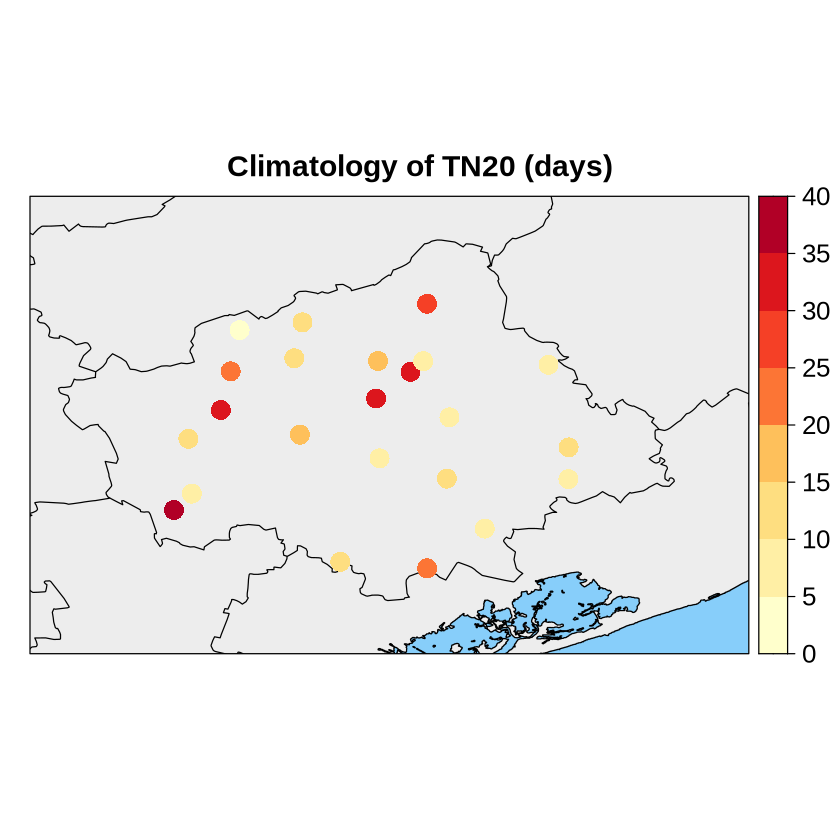

In [8]:
bk <-  seq(0, 40, 5)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlOrRd"))
cmap <- cols(cmap.nbins)
spatialPlot(climatology(TN20), cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Climatology of TN20 (days)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

Additional indices are calculated for daily maximum temperature, based on consecutive days surpassing a threshold. In this example we calculate periods (spells) of at least 5 days with maximum temperature over 30ºC (HW30). Similar code could be used to calculate HW35. An auxiliary function `binSpell` is needed to detect spells ans measure their length:

In [9]:
binSpell <- function(data) {
  data[is.na(data)] <- FALSE 
  ix <- c(which(data[-length(data)] != data[-1]), length(data)) 
 
  # output list
  out <- list()
  out$len <- diff(c(0, ix))
  out$val <- data[ix]
  return(out)
}

In [10]:
ls <-lapply(1:length(years), function(yy){
	obs.y <- subsetGrid(tasmax_obs, years=years[yy], season=4:9)
	index <- subsetDimension(obs.y, dimension="time",indices=1) 
	for(i in 1:dim(obs.y$Data)[2]){				
		bin <- binSpell(obs.y$Data[,i] > 30) # change threshold here if needed
		if(all(bin$len[which(bin$val)]==0)){
			index.aux <- NA # write NA if there are no spells
		} else{
		index.aux <- sum(bin$len[which(bin$val)] >= 5, na.rm = T) # change duration here if needed
		}
		index$Data[,i] <- index.aux
	}
	return(index)
})
HW30 <- bindGrid(ls, dimension = "time"); rm(ls) 


For rare events such as heatwaves, multi-year median instead of the mean is preferred since, in some locations, there are not even one per year.

[2026-02-24 16:39:23.80033] - Computing climatology...



[2026-02-24 16:39:23.802359] - Done.



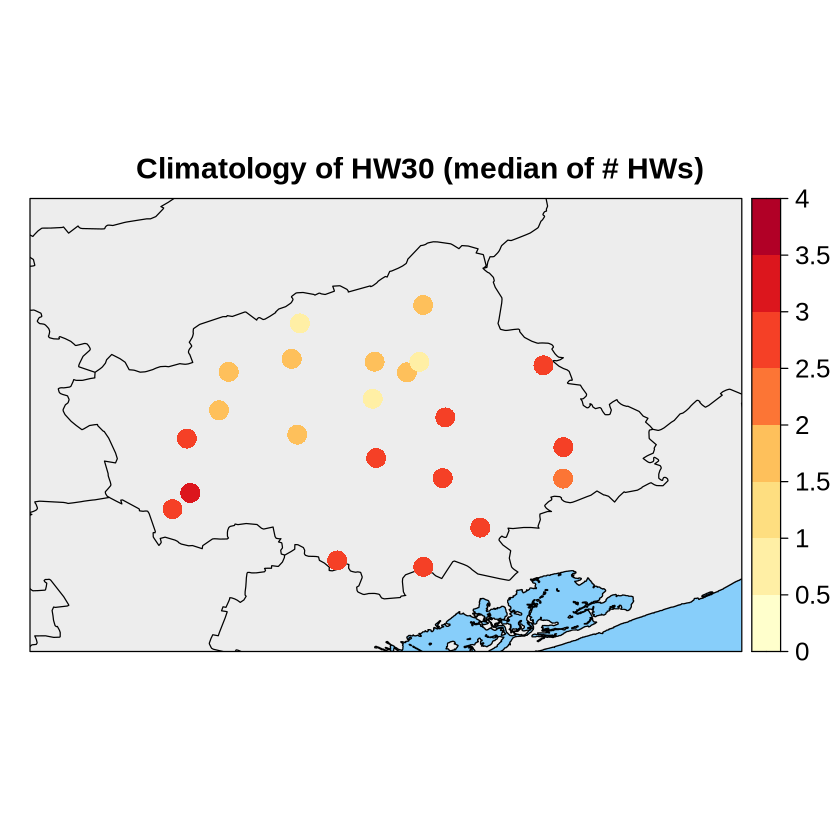

In [11]:
bk <-  seq(0,4,0.5)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- colorRampPalette(brewer.pal(8,"YlOrRd"))
cmap <- cols(cmap.nbins)
spatialPlot(climatology(HW30, clim.fun = list(FUN = "median", na.rm = TRUE)), cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Climatology of HW30 (median of # HWs)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

#### Precipitation indices

In [12]:
ls <-lapply(1:length(years), function(yy){
	obs.y <- subsetGrid(pr_obs, years=years[yy], season=4:9)
	index <- subsetDimension(obs.y, dimension="time",indices=1)  
	for(i in 1:dim(obs.y$Data)[2]){
		bin <- binSpell(obs.y$Data[,i] < 1) # CDD (wet day is below 1mm)
		if(all(bin$len[which(bin$val)]==0)){
			index.aux <- NA # write NA if there are no spells
		} else{
		index.aux <- mean(bin$len[which(bin$val) ], na.rm = T) # mean duration of dry spells (change condition here if you want to calculate CWD instead)
		}
		index$Data[,i] <- index.aux
		rm(index.aux)
	}
	return(index)
})
CDD <- bindGrid(ls, dimension = "time"); rm(ls)

[2026-02-24 16:39:24.44457] - Computing climatology...

[2026-02-24 16:39:24.445467] - Done.



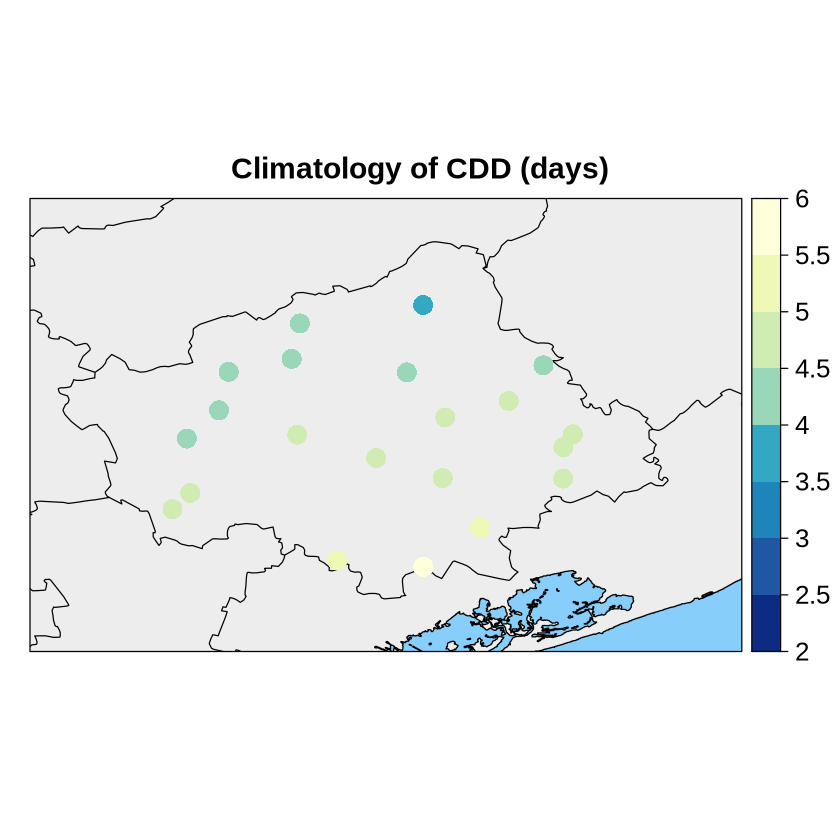

In [13]:
bk <-  seq(2,6,0.5)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- cols <- colorRampPalette(brewer.pal(8,"YlGnBu"))
cmap <- rev(cols(cmap.nbins))
spatialPlot(climatology(CDD), cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Climatology of CDD (days)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

In [14]:
seas <- 4:9
ls0 <-lapply(1:length(seas), function(s){		
ls <-lapply(1:length(years), function(yy){
	obs.y <- subsetGrid(pr_obs, years=years[yy], season=seas[s])
	index <- subsetDimension(obs.y, dimension="time",indices=1)  
	for(i in 1:dim(obs.y$Data)[2]){
		if(sum(is.na(obs.y$Data[,i]))!=length(obs.y$Data[,i])){
			index.aux <- sum(obs.y$Data[,i], na.rm = TRUE)
		} else{index.aux <- NA}# NA if all data are NA (otherwise sum will be zero)
		index$Data[,i] <- index.aux
		rm(index.aux)
	}
	return(index)
})
aux <- bindGrid(ls, dimension = "time")
return(aux); rm(ls)
}) # each element of the list is accumulated pr in one month
prACC <- bindGrid(ls0, dimension = "member"); rm(ls0) # each month is saved as member	

[2026-02-24 16:39:25.861471] - Computing climatology...

[2026-02-24 16:39:25.863412] - Done.



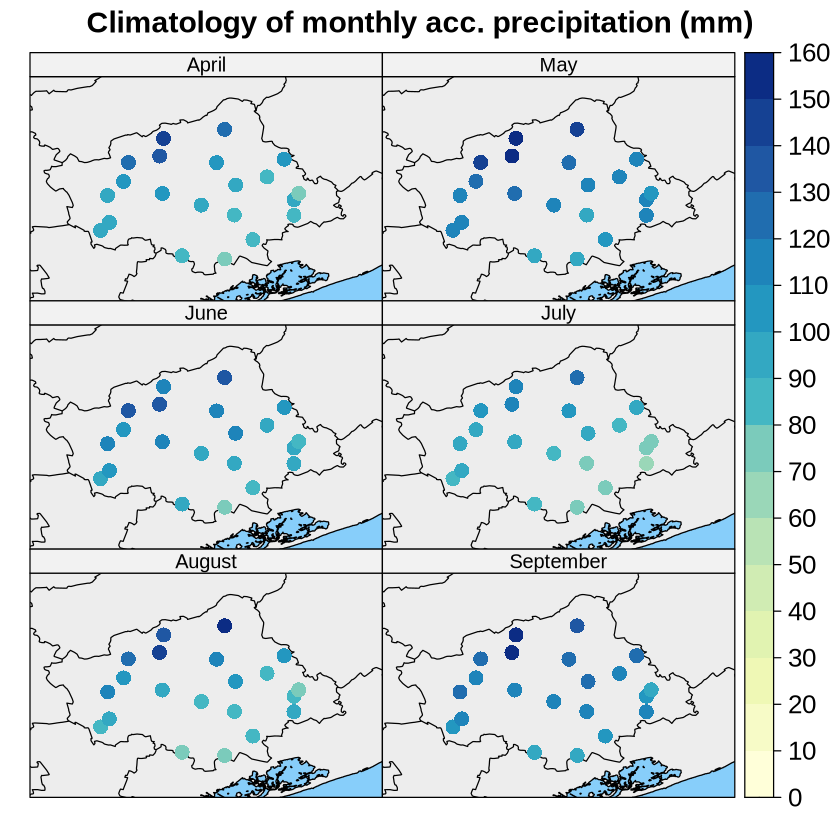

In [15]:
bk <- seq(0,160,10)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- cols <- colorRampPalette(brewer.pal(8,"YlGnBu"))
cmap <- cols(cmap.nbins)
spatialPlot(climatology(prACC), cex=1.5, xlim=lons, ylim=lats, as.table=T,layout = c(2,3), 
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    names.attr = c("April", "May", "June", "July", "August", "September"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Climatology of monthly acc. precipitation (mm)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

#### Humidity indices

In [16]:
ls <-lapply(1:length(years), function(yy){
	obs.y <- subsetGrid(hurs_obs, years=years[yy], season=4:9) # change variable here if needed
	index <- subsetDimension(obs.y, dimension="time",indices=1) 
	for(i in 1:dim(obs.y$Data)[2]){
		if(sum(is.na(obs.y$Data[,i]))!=length(obs.y$Data[,i])){
			index.aux <- sum(obs.y$Data[,i] > 85, na.rm = TRUE) # change threshold here if needed
		} else{index.aux <- NA} # NA if all data are NA (otherwise sum will be zero)
		index$Data[,i] <- index.aux			
		rm(index.aux)
	}
	return(index)
	})
HU85 <- bindGrid(ls, dimension = "time"); rm(ls)

[2026-02-24 16:39:28.970068] - Computing climatology...

[2026-02-24 16:39:28.971698] - Done.



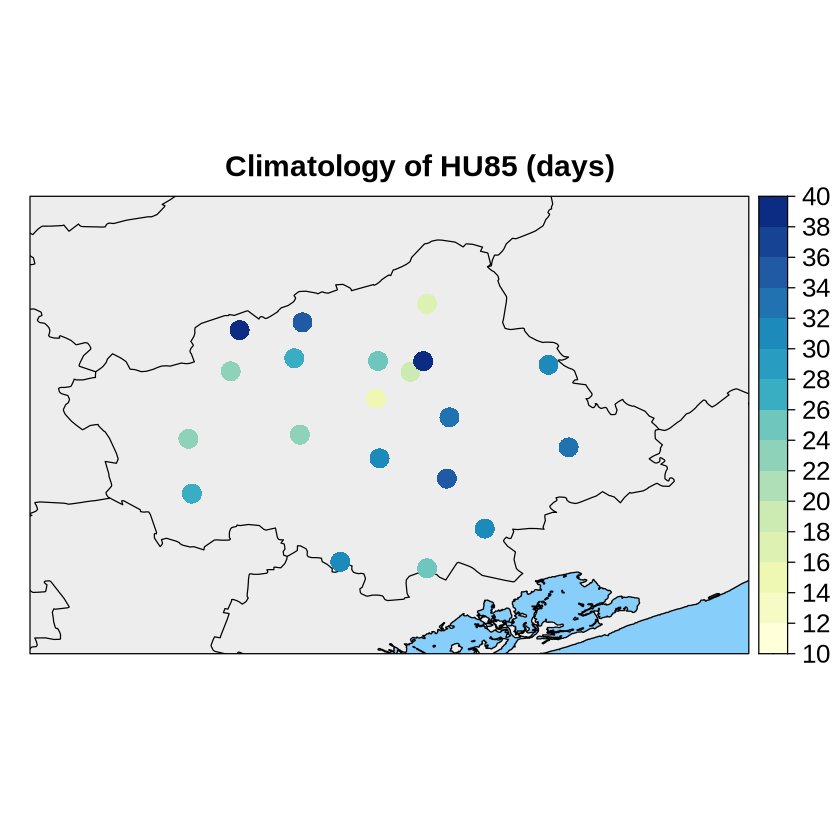

In [17]:
bk <-  seq(10,40,2)
cmap.nbins <- length(bk)  # number of bins in colorbar
cols <- cols <- colorRampPalette(brewer.pal(8,"YlGnBu"))
cmap <- cols(cmap.nbins)
spatialPlot(climatology(HU85), cex=2, xlim=lons, ylim=lats,
    backdrop.theme = "none",  sp.layout = list(sh, col = "black", fill="grey93"),
    par.settings = list(panel.background=list(col="lightskyblue")), 
    col.regions = cmap, set.min = min(bk), set.max = max(bk),
    cuts = bk, main = list(label="Climatology of HU85 (days)", cex=1.5),
    par.strip.text = list(cex = 1),
    colorkey = list(right = list(fun = draw.colorkey, args = list(key = list(at =bk, col = cmap, labels = list(at = bk,cex=1.3,labels = bk))))))

### Session Information

In [18]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/ana/micromamba/envs/prosecco/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Madrid
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-3 sp_2.2-0           lattice_0.22-7     visualizeR_1.6.4  
[5] transformeR_2.2.2 

loaded via a namespace (and not attached):
 [1] verification_1.45       jpeg_0.1-11             digest_0.6.39          
 